<a href="https://colab.research.google.com/github/EnochYounceSAIC/colab/blob/main/weektwo/chromatic_dispersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
length = 3000
span = 100
lambda_light = 1550e-9
f_light = 3e8/lambda_light
#fiber data sheet used : https://www.corning.com/media/worldwide/coc/documents/Fiber/product-information-sheets/PI-1470-AEN.pdf
dispersion = 18 #ps/nm/km
distance = np.arange(0,length,1)


In [69]:

#This code is AI- assisted and is used for the generation of psuedorandom data to test the dispersion
def gen_random_data(type, amount):
  if type == '16qam':
    # 1. Generate random bits
    random_bits = np.random.randint(0, 2, 4*amount)

    # 2. Reshape into groups of 4 bits
    bit_groups = random_bits.reshape(-1, 4)

    # 3. Map 4-bit groups to 16-QAM constellation points
    # Define the 16-QAM constellation mapping
    qam16_mapping = {
        (0, 0, 0, 0): -3 - 3j, (0, 0, 0, 1): -3 - 1j, (0, 0, 1, 0): -3 + 3j, (0, 0, 1, 1): -3 + 1j,
        (0, 1, 0, 0): -1 - 3j, (0, 1, 0, 1): -1 - 1j, (0, 1, 1, 0): -1 + 3j, (0, 1, 1, 1): -1 + 1j,
        (1, 0, 0, 0):  3 - 3j, (1, 0, 0, 1):  3 - 1j, (1, 0, 1, 0):  3 + 3j, (1, 0, 1, 1):  3 + 1j,
        (1, 1, 0, 0):  1 - 3j, (1, 1, 0, 1):  1 - 1j, (1, 1, 1, 0):  1 + 3j, (1, 1, 1, 1):  1 + 1j
    }

    qam16_symbols = np.array([qam16_mapping[tuple(group)] for group in bit_groups])
    return qam16_symbols
  elif type == 'qpsk':
    # 1. Generate random bits
    random_bits_qpsk = np.random.randint(0, 2, 2*amount)

    # 2. Reshape into groups of 2 bits
    bit_groups_qpsk = random_bits_qpsk.reshape(-1, 2)

    # 3. Map 2-bit groups to QPSK constellation points
    # Define the QPSK constellation mapping
    qpsk_mapping = {
        (0, 0): -1 - 1j,
        (0, 1): -1 + 1j,
        (1, 0):  1 - 1j,
        (1, 1):  1 + 1j
    }

    qpsk_symbols = np.array([qpsk_mapping[tuple(group)] for group in bit_groups_qpsk])
    return qpsk_symbols
  elif type == 'bpsk':
    # 1. Generate random bits (0 or 1)
    random_bits_bpsk = np.random.randint(0, 2, amount)

    # 2. Map these bits to BPSK constellation points: 0 maps to -1, and 1 maps to 1.
    # This can be done by multiplying by 2 and subtracting 1: 0*2 - 1 = -1, 1*2 - 1 = 1
    bpsk_symbols = 2 * random_bits_bpsk - 1


Length of the shaped signal: 25040


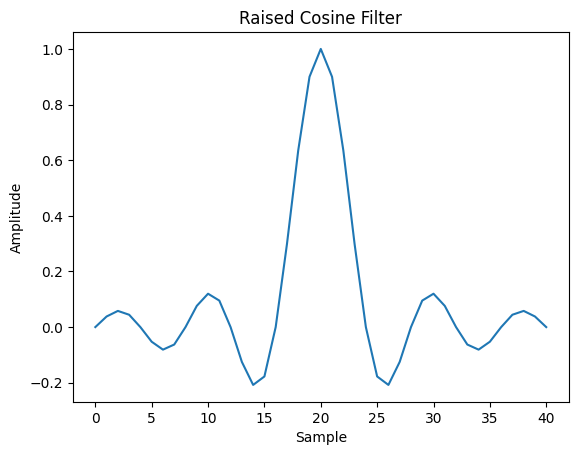

In [74]:
#500 should be a good dataset to see any alterations
data = gen_random_data('qpsk', 500)
#samples per signal at 50 for now
sps = 50

#RRC
fs = 4
num_weights = 41
alpha = 0.1
x = 0.9999*np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/fs
raised_cos_weights = np.sinc(x)*(np.cos(alpha*np.pi*x)/(1-((2*alpha*x)**2)))

# Normalize the weights and graph

plt.plot(raised_cos_weights)
plt.title('Raised Cosine Filter')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

#pulse shaping
# 1. Upsample the symbols by inserting zeros
upsampled_symbols = np.zeros(len(data) * sps, dtype=complex)
upsampled_symbols[::sps] = data

# 2. Convolve the upsampled signal with the raised_cos_weights filter.
shaped_signal = np.convolve(upsampled_symbols, raised_cos_weights, mode='full')

# 3. Print the length of the shaped signal to confirm
print(f"Length of the shaped signal: {len(shaped_signal)}")

Text(0, 0.5, 'Amplitude')

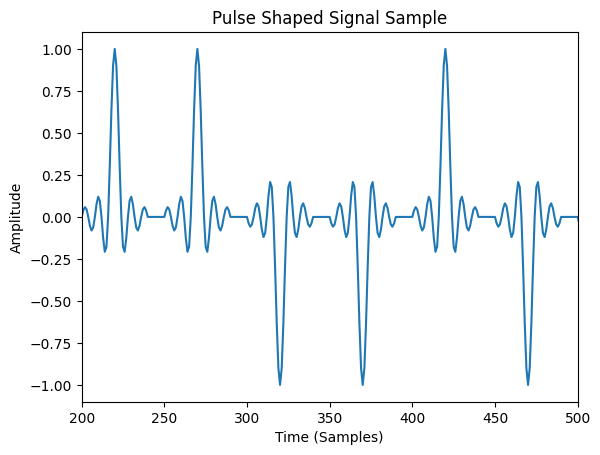

In [75]:
plt.plot(np.real(shaped_signal))
#arbitrary range to show a few pulses
plt.xlim(200,500)
plt.title('Pulse Shaped Signal Sample')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')

In [76]:
#assuming 1 symbol per second
freq_axis = np.fft.fftfreq(len(shaped_signal), 1/sps)


dispersion_operator = np.exp(1j * 0.5 * dispersion * (2 * np.pi * freq_axis)**2 * location)


#
# 1. Perform FFT on the shaped_signal
shaped_signal_freq = np.fft.fft(shaped_signal)

# 2. Multiply by the dispersion_operator
dispersed_signal_freq = shaped_signal_freq * dispersion_operator

# 3. Perform IFFT to transform back to time domain
dispersed_signal = np.fft.ifft(dispersed_signal_freq)

# 4. Take the real part for visualization
dispersed_signal_real = np.real(dispersed_signal)

#

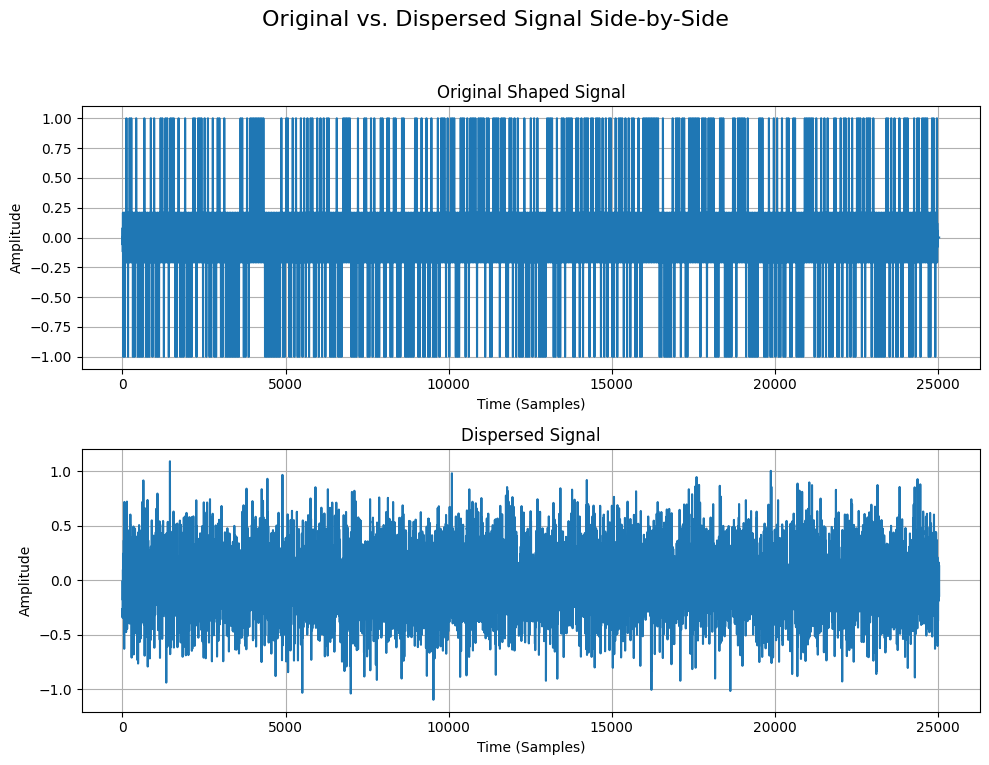

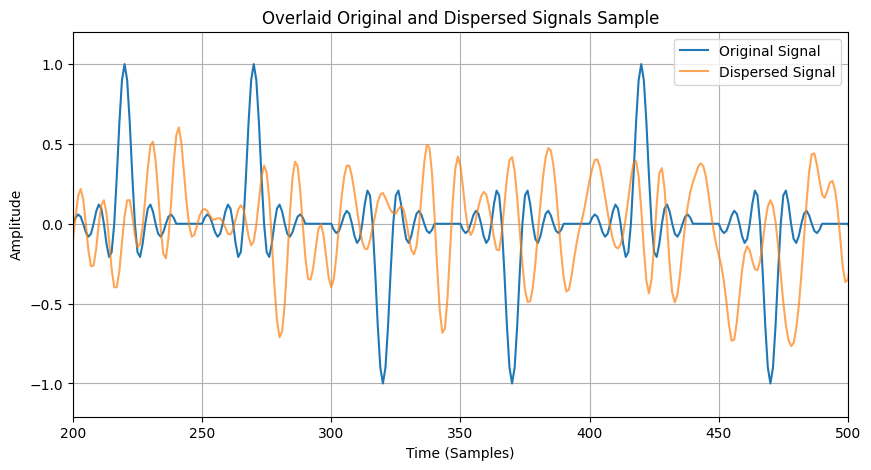

In [77]:
# 1. Create a figure and a set of subplots for side-by-side plots
fig1, axes = plt.subplots(2, 1, figsize=(10, 8))

# 2. Plot the real part of the shaped_signal on the first subplot
axes[0].plot(np.real(shaped_signal))

# 3. Set the title of the first subplot
axes[0].set_title('Original Shaped Signal')
axes[0].set_xlabel('Time (Samples)')

axes[0].set_ylabel('Amplitude')
axes[0].grid(True)

# 4. Plot the real part of the dispersed_signal on the second subplot
axes[1].plot(np.real(dispersed_signal))

# 5. Set the title of the second subplot
axes[1].set_title('Dispersed Signal')
axes[1].set_xlabel('Time (Samples)')

axes[1].set_ylabel('Amplitude')
axes[1].grid(True)


# 6. Add a title to the overall figure
fig1.suptitle('Original vs. Dispersed Signal Side-by-Side', fontsize=16)

# 7. Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# 8. Create a new figure for the overlaid plot
fig2 = plt.figure(figsize=(10, 5))
plt.xlim(200,500)

# 9. Plot the real part of the shaped_signal on this new figure
plt.plot(np.real(shaped_signal), label='Original Signal')

# 10. Plot the real part of the dispersed_signal on the same figure
plt.plot(np.real(dispersed_signal), label='Dispersed Signal', alpha=0.7) # Use alpha for better visibility

# 11. Add a legend to distinguish between the original and dispersed signals
plt.legend()

# 12. Set the title of this overlaid plot
plt.title('Overlaid Original and Dispersed Signals Sample')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.grid(True)

# 13. Display both figures
plt.show()

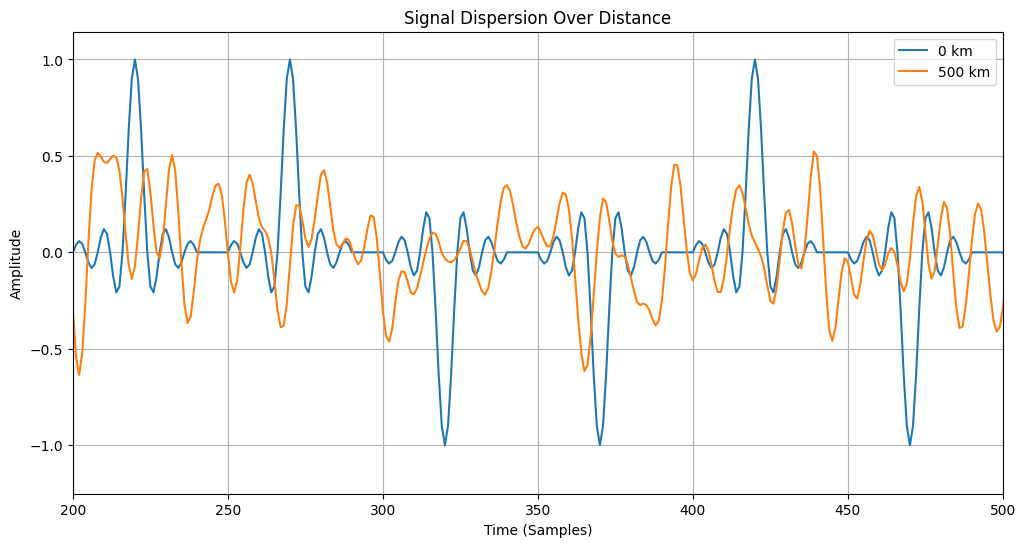

In [84]:
# Select a few distances along the fiber length to show the effect of dispersion
distances_to_plot = [0, 500]

plt.figure(figsize=(12, 6))
plt.title('Signal Dispersion Over Distance')
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(200,500) # Adjusted xlim for better visualization across different distances


for dist in distances_to_plot:
    # Calculate the dispersion operator for the current distance
    dispersion_operator_dist = np.exp(1j * 0.5 * dispersion * (2 * np.pi * freq_axis)**2 * dist)

    # Apply the dispersion operator in the frequency domain
    dispersed_signal_freq_dist = shaped_signal_freq * dispersion_operator_dist

    # Transform back to the time domain
    dispersed_signal_dist = np.fft.ifft(dispersed_signal_freq_dist)

    # Plot the real part of the dispersed signal for the current distance
    plt.plot(np.real(dispersed_signal_dist), label=f'{dist} km')

plt.legend()
plt.show()